In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import joblib
from fbprophet import Prophet


# Load data with all imputation

In [2]:
df = pd.read_csv('data/df_after_all_imputations.csv', date_parser=['Date'])
df.sort_values(by=['Location_ID', 'Date'], inplace=True)
df.reset_index(inplace=True);
df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
print(df.iloc[:1,0].values)
df['Date'] = df['Date'].astype('datetime64[ns]')
print(df.iloc[:1,0].values)
location_id_all = list(df['Location_ID'].unique())[-2:]
# features_all = df.columns[2:-4][:2]
features_all = df.columns[2:-4]
print(df.shape)

['2008-07-01']
['2008-07-01T00:00:00.000000000']
(142193, 25)


In [3]:
# назвать даты начала и окончания train (для одного Location_ID)
# подготовить train и test DF
def  train_test_split_ts(df, cur_Location_ID, name_f, \
                         d_train_start, d_train_end, period):
    name_d = 'Date'
    name_loc = 'Location_ID'
    d_test_start = d_train_end
    d_test_end = d_test_start + pd.Timedelta(period, unit='D')

    mask_train = (df[name_loc] == cur_Location_ID) & (df[name_d] >= d_train_start) & (df[name_d] < d_train_end)
    df_train = df[mask_train][[name_d, name_f]]
    df_train = df_train.rename(columns={name_d: 'ds', name_f: 'y'})

    mask_test = (df[name_loc] == cur_Location_ID) & (df[name_d] >= d_test_start) & (df[name_d] < d_test_end)
    df_test = df[mask_test][[name_d, name_f]]
    df_test = df_test.rename(columns={name_d: 'ds', name_f: 'y'})
    return df_train, df_test

def predict_prophet(df, period):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=period)
    forecast = m.predict(future)
    return forecast, m

def preprocessing_befor_load(df):
    # convert dates
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['year'] = df['Date'].dt.year.astype('uint16')
    df['month'] = df['Date'].dt.month.astype('uint8')
    df['season'] = df['month'].apply(lambda x: 1 if x in [1,11,12] else 
                                    2 if x in [3, 4, 5] else 
                                    3 if x in [6, 7, 8] else 4).astype('uint8')
    # replace wind directions with numeric
    wind_rose = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    dict_replacer = dict(zip(wind_rose, range(len(wind_rose))))
    df.replace(dict_replacer, inplace=True)

    # drop
    df.drop(['Unnamed: 0', 'Date'], axis=1, inplace=True)
    return df

# best_model_file_name = 'models/tuNning/cat-tunning_model-[GridSearchCV][02-22-2020, 20-51-52].pkl'
# clf = joblib.load(best_model_file_name)
file_name_log2 = 'models/df_log2.pkl'
df_log2 = joblib.load(file_name_log2)
best_model_file_name = df_log2.sort_values(by=['roc_auc_test'], ascending=False).loc[:,'model'].to_list()[0]
print(best_model_file_name)
clf = joblib.load(best_model_file_name)

models/tunning\cat-tunning_model-[GridSearchCV][02-22-2020, 20-51-52].pkl


# собираю main файл

In [48]:
# main_load = joblib.load('data/main0_sum.joblib')
# main_load = joblib.load('data/main0_local_04-06.joblib')
# main_load = joblib.load('data/main0_local_07-09.joblib')
# main_load = joblib.load('data/main0_local2_10-13.joblib')
# main_load = joblib.load('data/main0_colab_14-15.joblib')
# main_load = joblib.load('data/main0_colab_16-17.joblib')
# main_load = joblib.load('data/main0_local_18-19.joblib')
# main_load = joblib.load('data/main0_local_20-21.joblib')
main_load = joblib.load('data/main0_local_20-21.joblib')

main_load

,Date,Iteration,Location_ID,Cloud9am_0,Cloud9am_1,Cloud9am_2,Cloud9am_3,Cloud9am_4,Cloud9am_5,Cloud9am_6,...,WindSpeed3pm_4,WindSpeed3pm_5,WindSpeed3pm_6,WindSpeed3pm_7,WindSpeed3pm_8,WindSpeed3pm_9,WindSpeed3pm_10,WindSpeed3pm_11,WindSpeed3pm_12,WindSpeed3pm_13
0,2017-01-01,0,0,4.699484,4.983972,4.881393,5.095469,5.302419,5.245360,5.462578,...,14.935626,14.411134,14.294407,14.929693,14.009098,14.961797,14.709408,15.346001,14.800984,14.654416
0,2017-01-01,0,1,5.135289,5.398842,5.212782,5.074140,3.851562,4.525111,4.093440,...,8.294091,9.583034,8.227794,7.857446,10.818032,7.938333,6.673517,8.049251,9.856130,8.977726
0,2017-01-01,0,2,4.675405,4.417142,4.809931,4.367263,4.346325,4.521204,4.256626,...,17.178765,16.097383,15.887463,15.984827,15.987942,15.213004,16.171698,16.527208,15.488708,15.348503
0,2017-01-01,0,3,6.094625,5.945498,5.613265,6.057662,5.828211,5.515174,5.295105,...,16.698214,18.629935,19.974716,18.840877,19.889243,20.080631,19.883026,20.203145,22.180018,23.498951
0,2017-01-01,0,4,4.575862,4.628564,4.587344,4.436987,4.552758,4.841915,4.781089,...,13.862894,14.269264,14.235380,14.594798,12.614272,14.194874,13.994135,13.367061,13.730930,13.671080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-01,0,44,6.086614,5.866671,5.736453,6.202469,5.886803,6.181351,6.307330,...,16.677670,15.331740,17.136480,16.354429,16.526768,18.161020,17.147667,17.920105,16.478241,18.180252
0,2017-01-01,0,45,6.419029,5.920392,5.487428,6.168192,6.580294,6.090932,6.514723,...,23.654654,21.886500,25.342061,21.002539,23.168694,24.762392,23.564896,23.994357,22.243922,25.714632
0,2017-01-01,0,46,4.143397,4.010303,3.982395,3.627977,3.824704,3.591503,3.430863,...,21.295304,22.002892,21.876599,21.972579,22.035898,22.201251,22.687858,22.560737,23.256745,23.087760
0,2017-01-01,0,47,5.837620,5.764234,5.481233,5.176080,5.324085,5.103330,4.775000,...,17.934386,18.441266,18.816119,19.086082,17.515915,20.378570,18.450429,19.696811,20.329812,20.789100


In [49]:
step = 49
iter_list = []
date_list = []
sdvig = len(main_all.groupby(['Date','Iteration']).count())
for iteration in range(len(main_load)):
#     print(iteration, sdvig + iteration // step)
    n_iter = sdvig + iteration // step
    iter_list.append(n_iter)
    date_list.append((pd.Timestamp('2017-01-01') + n_iter*pd.Timedelta(1, unit='D')).strftime('%Y-%m-%d'))
main_load['Iteration'] = iter_list
main_load['Date'] = date_list
#     main_load.iloc[0,0]
main_load

,Date,Iteration,Location_ID,Cloud9am_0,Cloud9am_1,Cloud9am_2,Cloud9am_3,Cloud9am_4,Cloud9am_5,Cloud9am_6,...,WindSpeed3pm_4,WindSpeed3pm_5,WindSpeed3pm_6,WindSpeed3pm_7,WindSpeed3pm_8,WindSpeed3pm_9,WindSpeed3pm_10,WindSpeed3pm_11,WindSpeed3pm_12,WindSpeed3pm_13
0,2017-01-21,20,0,4.699484,4.983972,4.881393,5.095469,5.302419,5.245360,5.462578,...,14.935626,14.411134,14.294407,14.929693,14.009098,14.961797,14.709408,15.346001,14.800984,14.654416
0,2017-01-21,20,1,5.135289,5.398842,5.212782,5.074140,3.851562,4.525111,4.093440,...,8.294091,9.583034,8.227794,7.857446,10.818032,7.938333,6.673517,8.049251,9.856130,8.977726
0,2017-01-21,20,2,4.675405,4.417142,4.809931,4.367263,4.346325,4.521204,4.256626,...,17.178765,16.097383,15.887463,15.984827,15.987942,15.213004,16.171698,16.527208,15.488708,15.348503
0,2017-01-21,20,3,6.094625,5.945498,5.613265,6.057662,5.828211,5.515174,5.295105,...,16.698214,18.629935,19.974716,18.840877,19.889243,20.080631,19.883026,20.203145,22.180018,23.498951
0,2017-01-21,20,4,4.575862,4.628564,4.587344,4.436987,4.552758,4.841915,4.781089,...,13.862894,14.269264,14.235380,14.594798,12.614272,14.194874,13.994135,13.367061,13.730930,13.671080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-01-22,21,44,6.086614,5.866671,5.736453,6.202469,5.886803,6.181351,6.307330,...,16.677670,15.331740,17.136480,16.354429,16.526768,18.161020,17.147667,17.920105,16.478241,18.180252
0,2017-01-22,21,45,6.419029,5.920392,5.487428,6.168192,6.580294,6.090932,6.514723,...,23.654654,21.886500,25.342061,21.002539,23.168694,24.762392,23.564896,23.994357,22.243922,25.714632
0,2017-01-22,21,46,4.143397,4.010303,3.982395,3.627977,3.824704,3.591503,3.430863,...,21.295304,22.002892,21.876599,21.972579,22.035898,22.201251,22.687858,22.560737,23.256745,23.087760
0,2017-01-22,21,47,5.837620,5.764234,5.481233,5.176080,5.324085,5.103330,4.775000,...,17.934386,18.441266,18.816119,19.086082,17.515915,20.378570,18.450429,19.696811,20.329812,20.789100


In [50]:
# main_all = main_load.copy()
main_all = pd.concat([main_all, main_load])
main_all.groupby(['Date','Iteration']).count()

,,Location_ID,Cloud9am_0,Cloud9am_1,Cloud9am_2,Cloud9am_3,Cloud9am_4,Cloud9am_5,Cloud9am_6,Cloud9am_7,Cloud9am_8,...,WindSpeed3pm_4,WindSpeed3pm_5,WindSpeed3pm_6,WindSpeed3pm_7,WindSpeed3pm_8,WindSpeed3pm_9,WindSpeed3pm_10,WindSpeed3pm_11,WindSpeed3pm_12,WindSpeed3pm_13
Date,Iteration,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-02,1,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-03,2,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-04,3,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-05,4,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-06,5,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-07,6,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-08,7,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2017-01-09,8,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49


In [52]:
# joblib.dump(main_all, f'data/main_all_00-21.joblib')

['data/main_all_00-21.joblib']

# Features as TimeSeries

i -0, location_id - 47, feature - Cloud9am
i -0, location_id - 47, feature - Cloud3pm
i -0, location_id - 47, feature - Humidity9am
i -0, location_id - 47, feature - Humidity3pm
i -0, location_id - 47, feature - Pressure9am
i -0, location_id - 47, feature - Pressure3pm
i -0, location_id - 47, feature - MinTemp
i -0, location_id - 47, feature - MaxTemp
i -0, location_id - 47, feature - Temp9am
i -0, location_id - 47, feature - Temp3pm
i -0, location_id - 47, feature - Rainfall


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - Evaporation


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - Sunshine


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindGustDir


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindGustSpeed


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindDir9am


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindDir3pm


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindSpeed9am


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



i -0, location_id - 47, feature - WindSpeed3pm


C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\makag\Anaconda3\lib\site-packages\fbprophet\plot.py:144: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



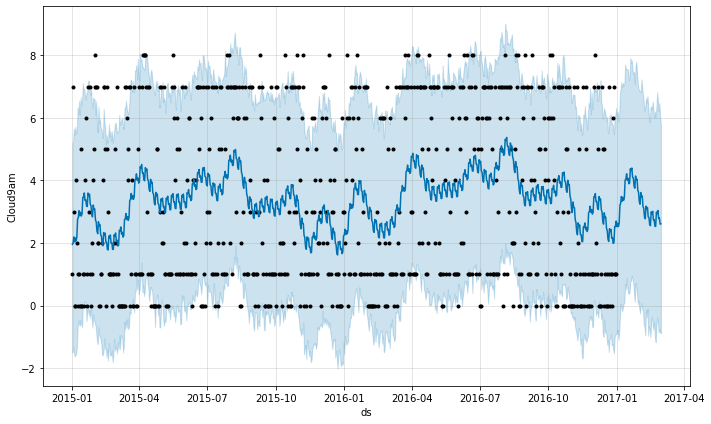

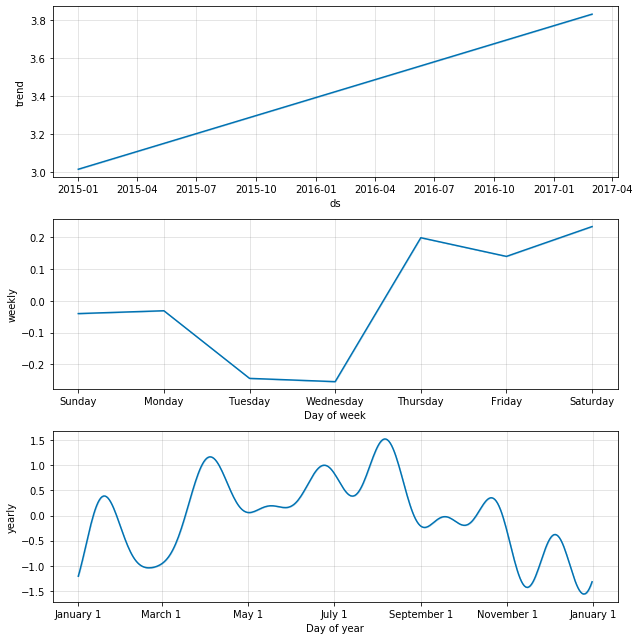

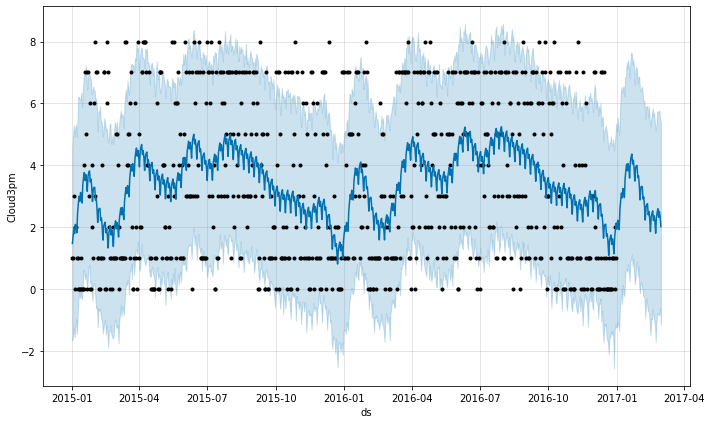

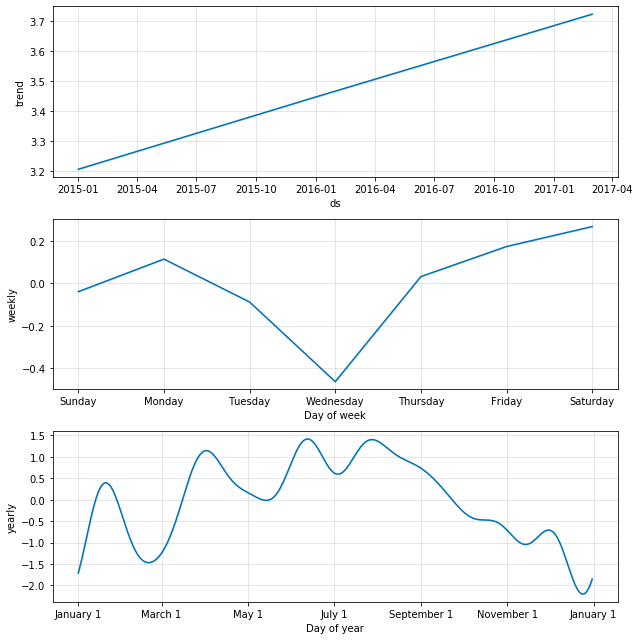

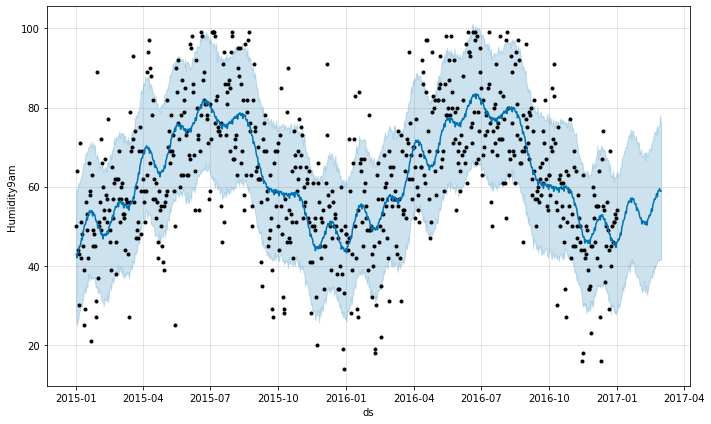

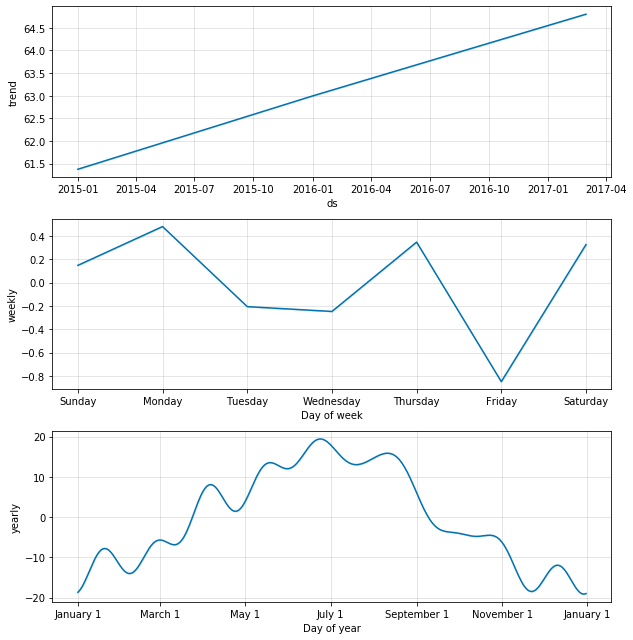

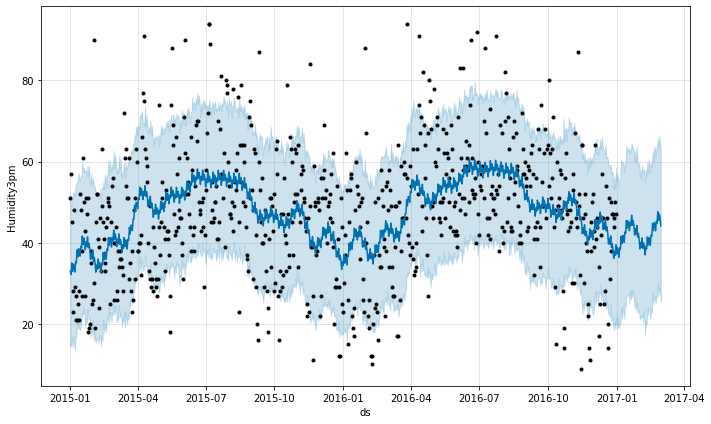

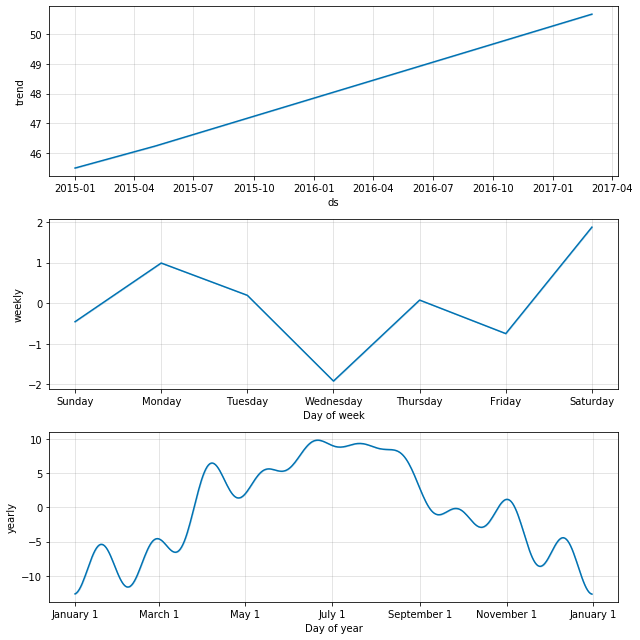

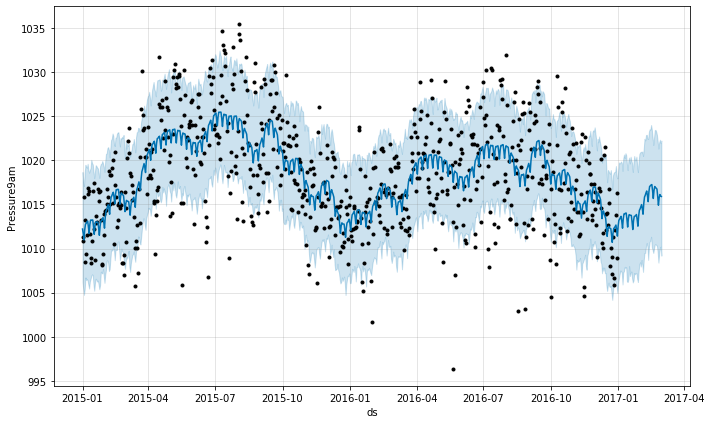

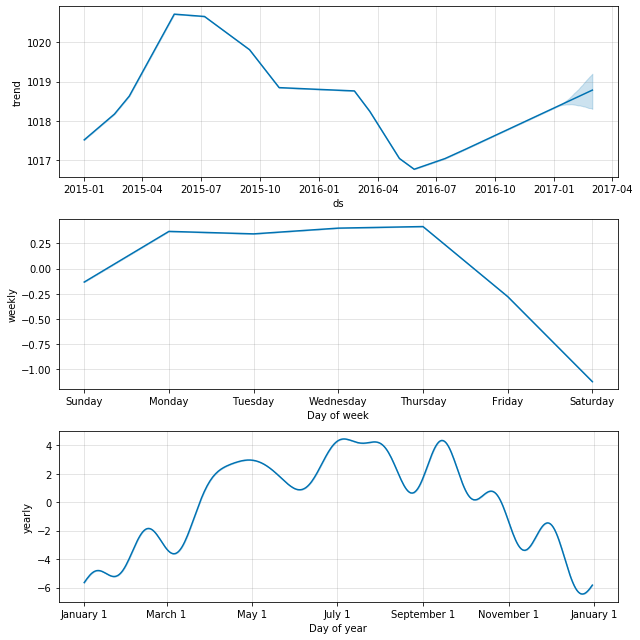

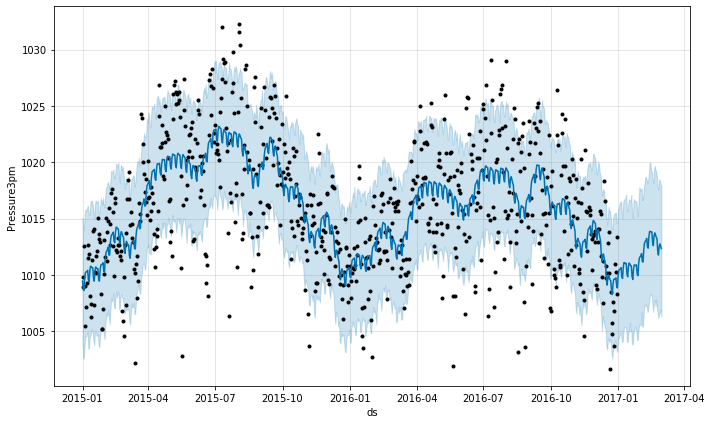

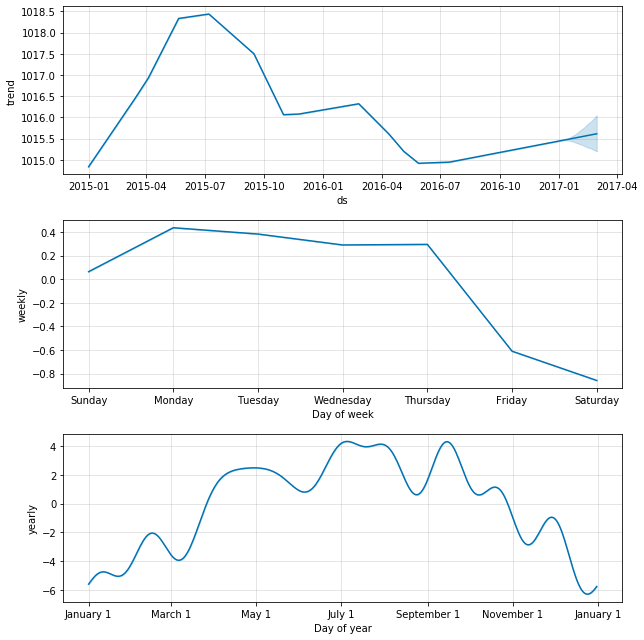

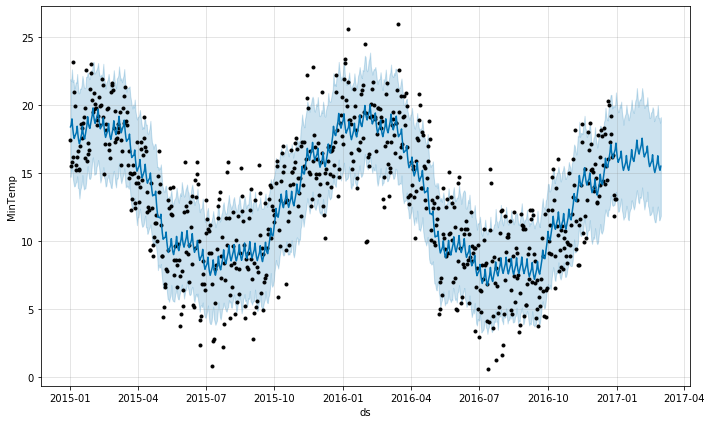

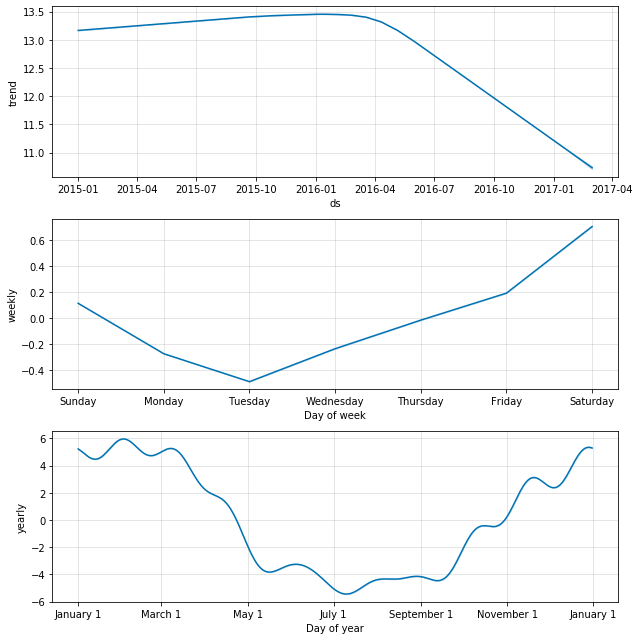

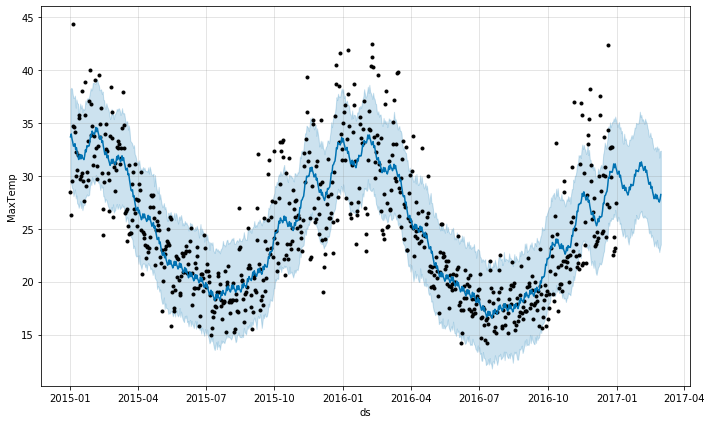

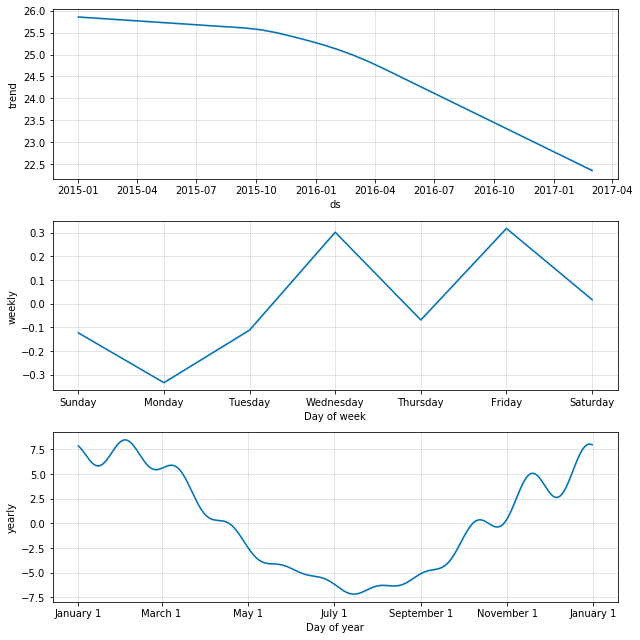

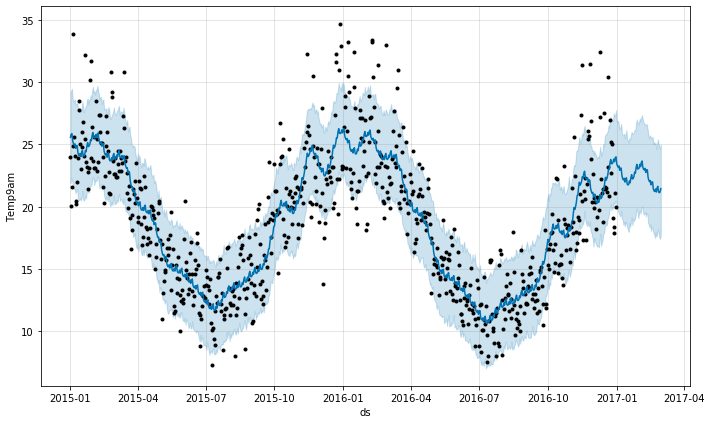

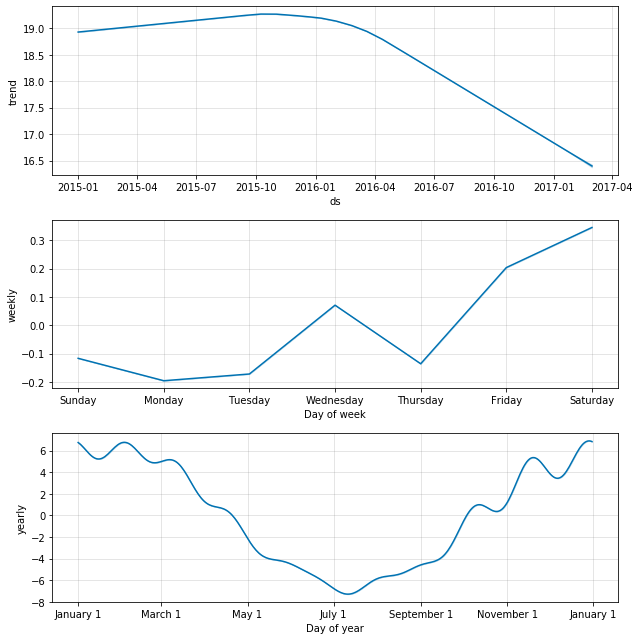

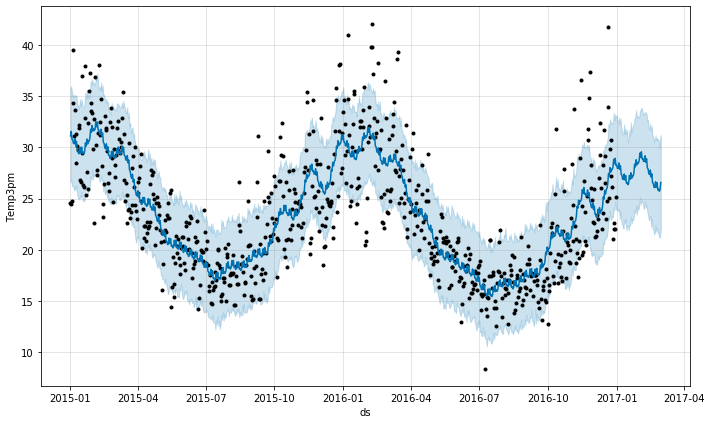

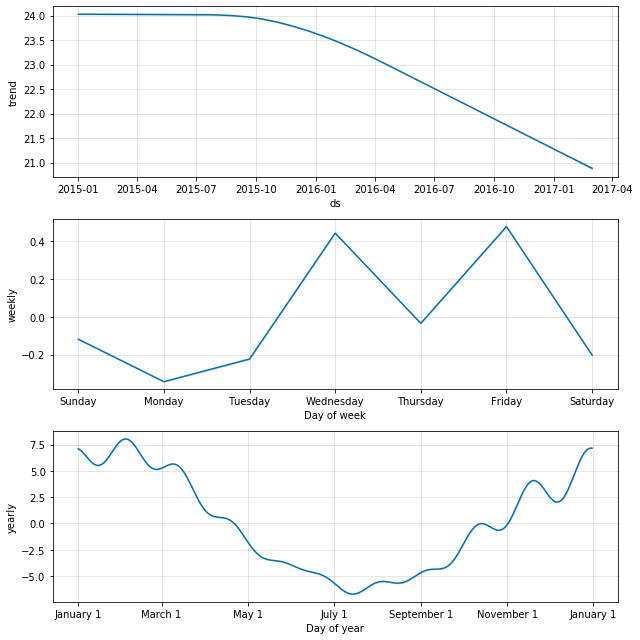

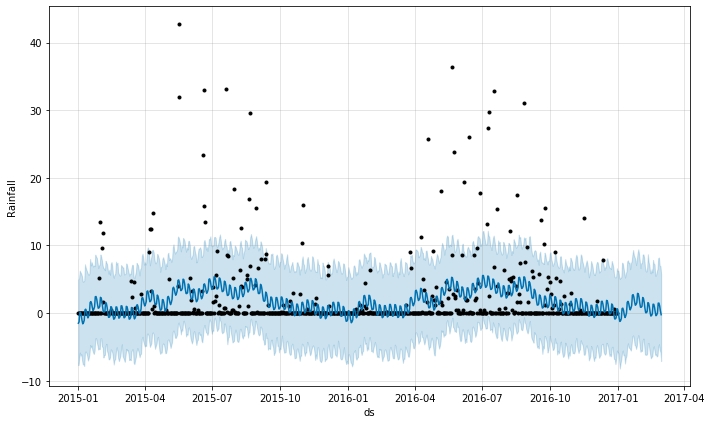

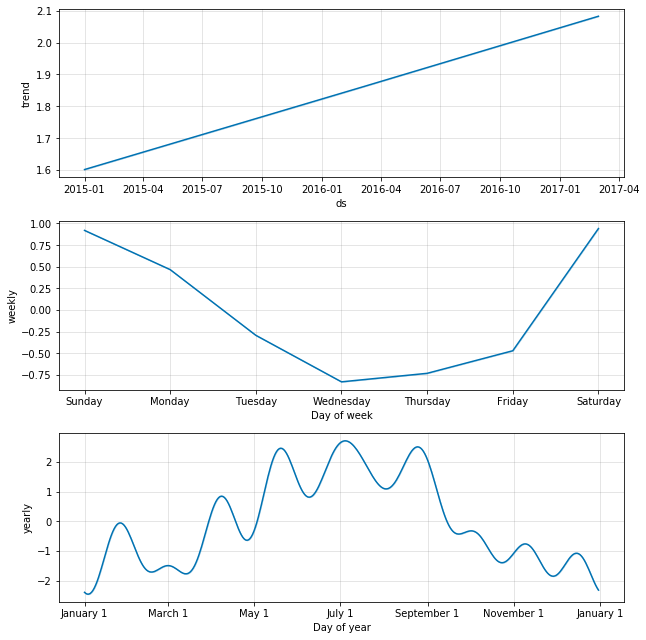

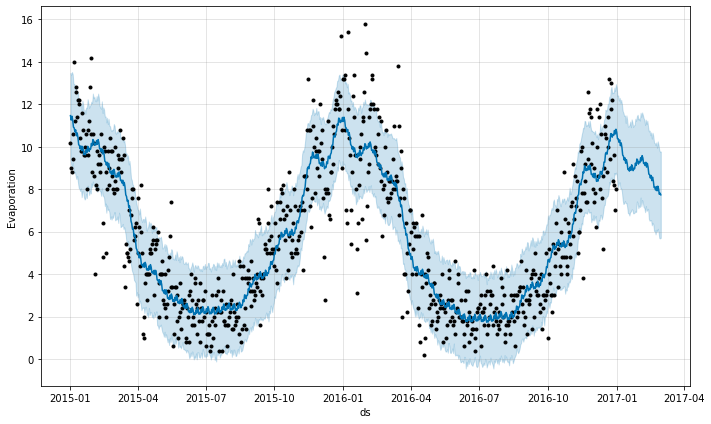

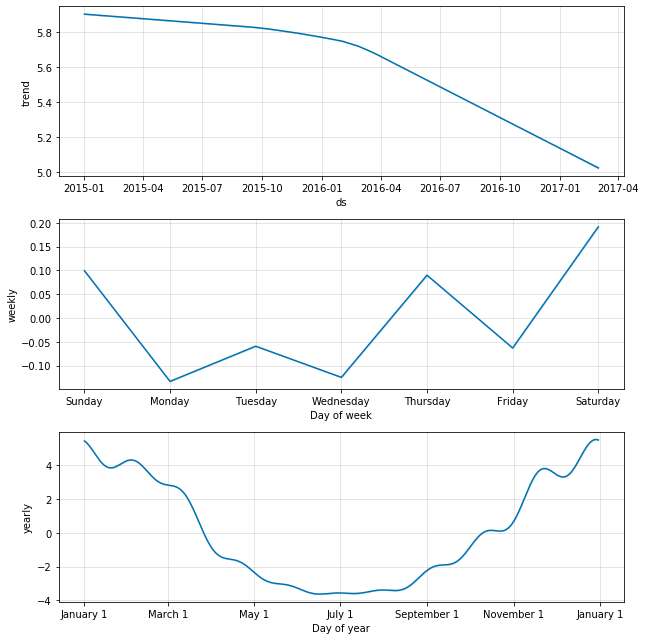

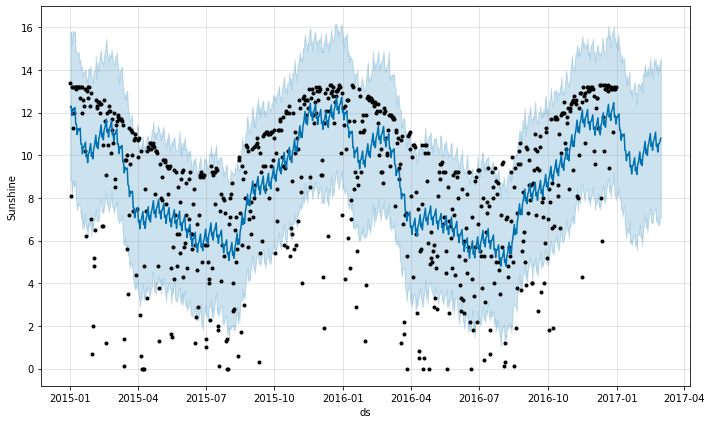

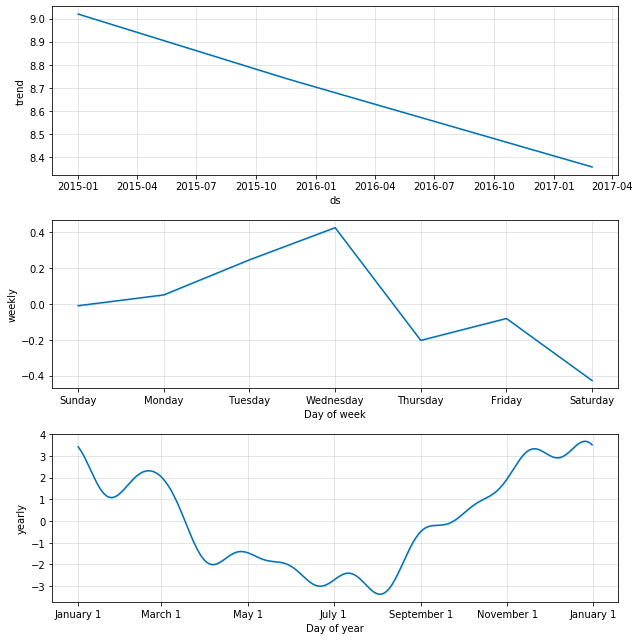

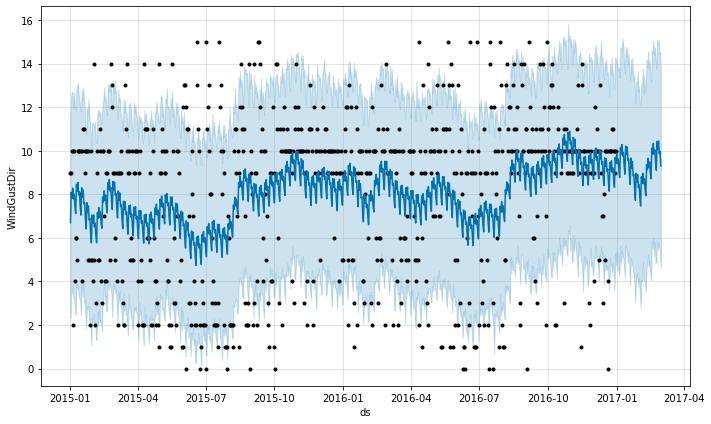

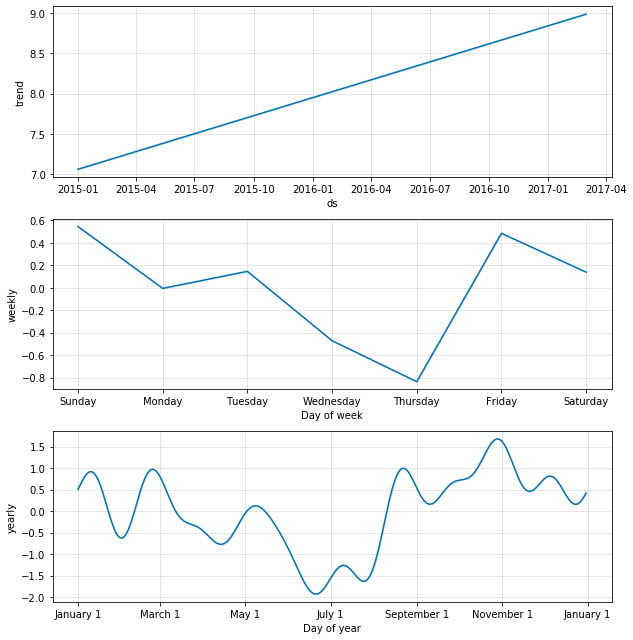

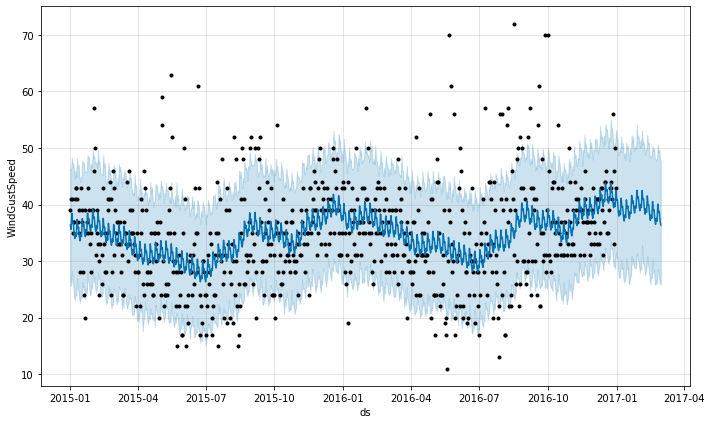

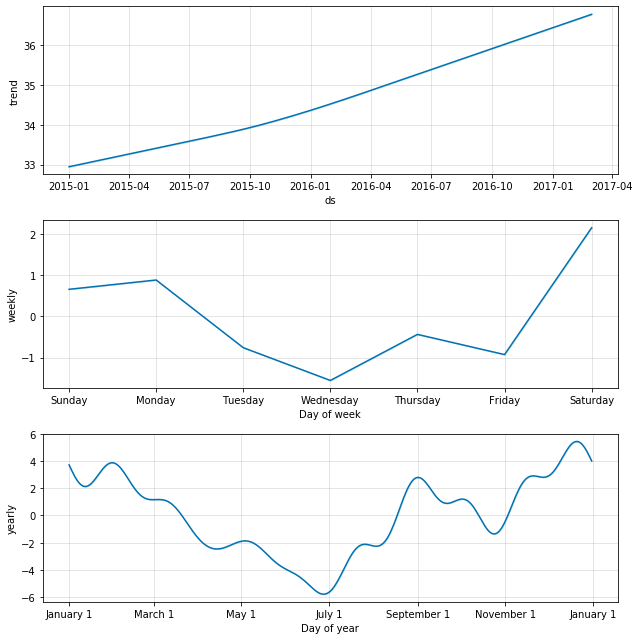

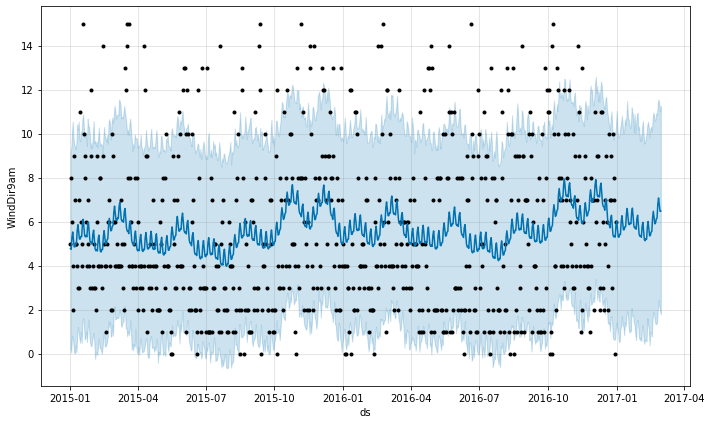

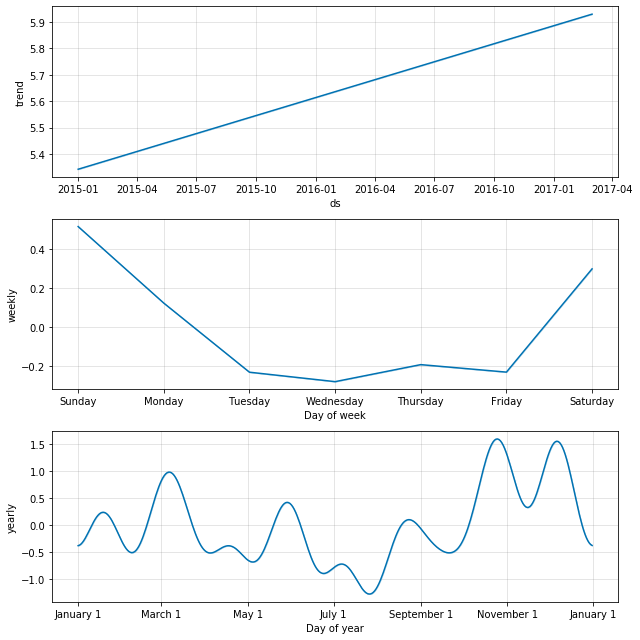

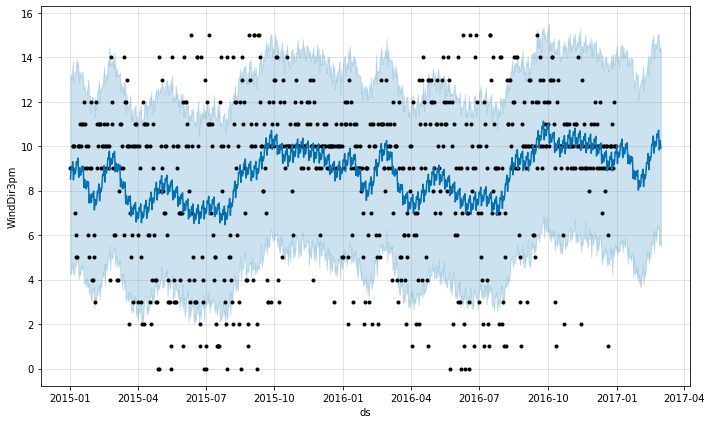

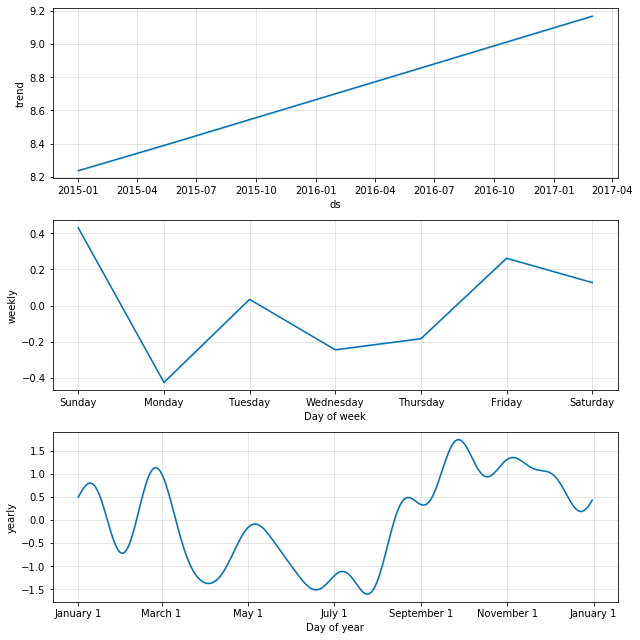

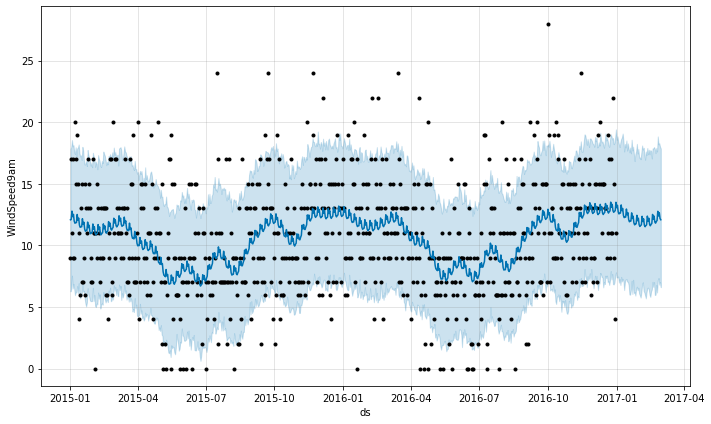

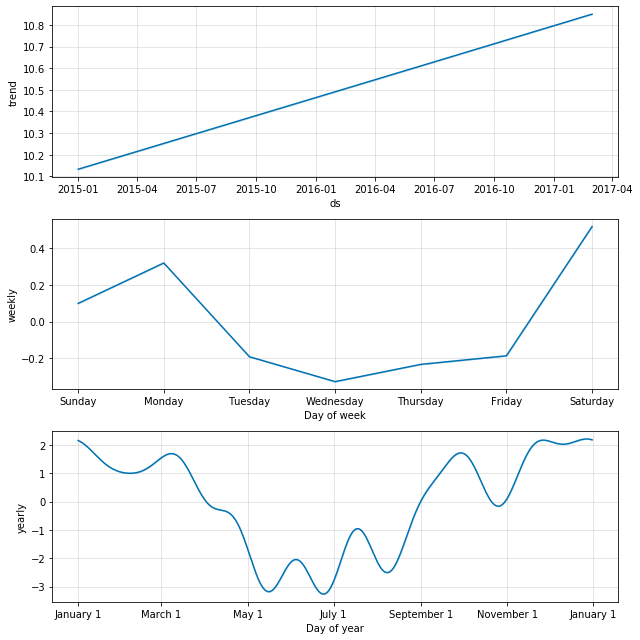

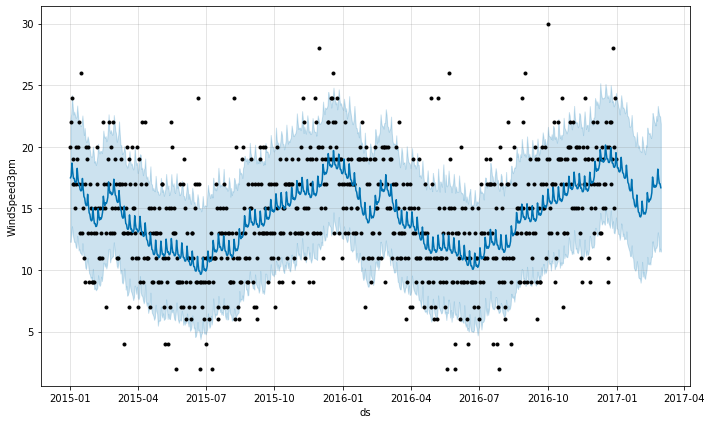

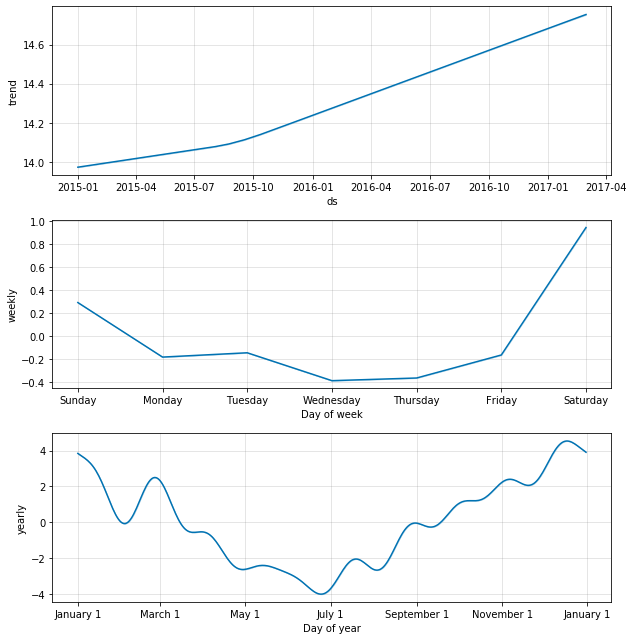

In [60]:
# Проирсовка наших фич в ТаймСириас
period = 60
d_train_start = '2015-01-01'
d_train_end = '2017-01-01'
# Для оценки предсказания нужно больше данных, начинаем смещаться на день вперед
iterations = 1
first_entrance = True
for i in range(iterations):
    d_train_start_cur = pd.Timestamp(d_train_start) + i*pd.Timedelta(1, unit='D')
    d_train_end_cur = pd.Timestamp(d_train_end) + i*pd.Timedelta(1, unit='D')
    temp_dict = {'Date': [d_train_end], 'Iteration': [0]}

    for location_id in location_id_all:
        temp_dict['Location_ID'] = [location_id]

        for feature in features_all[:]:
            print(f'i -{i}, location_id - {location_id}, feature - {feature}')
#             31 локация без пропусков
            X_train, X_test = train_test_split_ts(df, cur_Location_ID = 31, name_f=feature, \
                 d_train_start=d_train_start_cur, d_train_end=d_train_end_cur, period=period)

            forecast, m = predict_prophet(X_train, period)
            fig1 = m.plot(forecast, ylabel=feature);
#             fig1.set_figwidth(16)
#             fig1.set_figheight(8)
            fig2 = m.plot_components(forecast)
    

        break
    break